In [1]:
## v28 (50to1 by 24 fp bugfixed)

In [2]:
## imports

import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import genfromtxt
import pandas as pd
from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForMaskedLM
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.utils.data import DataLoader    
import torchvision.utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import random
# from pytorch_lightning.core.lightning import LightningModule
# from pytorch_lightning import Trainer
# import pytorch_lightning as pl
# from ray_lightning import RayPlugin, RayShardedPlugin
import ray
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
import os
import re
import requests
from tqdm.auto import tqdm
import pickle as pk
import time
import utils
from sklearn.decomposition import PCA
import math
from pprint import pprint
import shap
from captum.attr import IntegratedGradients
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import nltk, sklearn
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.5.
The scikit-learn version is 1.0.2.


In [3]:
## classes
class SiameseNetwork(torch.nn.Module):
    def __init__(self, len_embedding, abstract_len_embedding, use_irm=False, n_hidden_node=32, struct_code=0):
        '''
            struct_code {0=simple, 1=comple} structure
        '''
        
        super(SiameseNetwork, self).__init__()
        self.loss = nn.L1Loss(reduction="mean") 
        self.use_irm = use_irm
        self.len_embedding = len_embedding
        self.abstract_len_embedding = abstract_len_embedding  
        self.n_hidden_node = n_hidden_node
        #-----------change_1
        if struct_code == 0:
            self.nn_reg = nn.Sequential(
                nn.Linear(self.len_embedding, self.abstract_len_embedding),
            )
        elif struct_code == 1:
            self.nn_reg = nn.Sequential(
                nn.Linear(self.len_embedding, self.n_hidden_node),nn.ReLU(inplace=True),nn.BatchNorm1d(self.n_hidden_node),            
                nn.Linear(self.n_hidden_node, int(self.n_hidden_node/4)),nn.ReLU(inplace=True),nn.BatchNorm1d(int(self.n_hidden_node/4)),nn.Dropout(p=0.2),
                nn.Linear(int(self.n_hidden_node/4), self.abstract_len_embedding),
            )
        else:
            self.nn_reg = nn.Sequential(
                nn.Linear(self.len_embedding, self.abstract_len_embedding),
            )            
        #-----------change_1
        self.nn_final_reg = nn.Sequential(
            nn.Linear(self.abstract_len_embedding * 2, self.n_hidden_node),nn.ReLU(inplace=True),nn.BatchNorm1d(self.n_hidden_node),
            nn.Linear(self.n_hidden_node, int(self.n_hidden_node/4)),nn.ReLU(inplace=True),nn.BatchNorm1d(int(self.n_hidden_node/4)),nn.Dropout(p=0.2),
            nn.Linear(int(self.n_hidden_node/4), 1),
        )

    def forward_reg(self, x):
        output = self.nn_reg(x)
        return output

    def forward_final_reg(self, x):
        output = self.nn_final_reg(x)
        return output

    def forward(self, fp1, fp2):
        a = self.forward_reg(fp1)
        b = self.forward_reg(fp2)
        x = torch.cat([a, b], dim=1)  # hstack
        output = self.forward_final_reg(x)
        return output

    def compute_penalty(self, losses, dummy_w):
        g = grad(losses, dummy_w, create_graph=True)[0]
        r = g.pow(2)
        return r     

In [4]:
d_comp_lr = {
    (0, 0) : (6, "('0.01',)"),
    (0, 1) : (6, "('0.01',)"),
    (0, 2) : (6, "('0.01',)"),
    (0, 3) : (6, "('0.01',)"),
    (1, 0) : (6, "('0.01',)"),
    (1, 1) : (6, "('0.01',)"),
    (1, 2) : (6, "('0.01',)"),
    (1, 3) : (6, "('0.01',)"),
    (2, 0) : (6, "('0.01',)"),
    (2, 1) : (6, "('0.01',)"),
    (2, 2) : (6, "('0.01',)"),
    (2, 3) : (6, "('0.01',)"),
    (3, 0) : (6, "('0.01',)"),
    (3, 1) : (6, "('0.01',)"),
    (3, 2) : (6, "('0.01',)"),
    (3, 3) : (6, "('0.01',)"),
    (4, 0) : (6, "('0.01',)"),
    (4, 1) : (6, "('0.01',)"),
    (4, 2) : (6, "('0.01',)"),
    (4, 3) : (6, "('0.01',)"),
    (5, 0) : (6, "('0.01',)"),
    (5, 1) : (6, "('0.01',)"),
    (5, 2) : (6, "('0.01',)"),
    (5, 3) : (6, "('0.1',)"),
    (6, 0) : (6, "('0.01',)"),
    (6, 1) : (6, "('0.01',)"),
    (6, 2) : (6, "('0.01',)"),
    (6, 3) : (6, "('0.1',)"),
    (7, 0) : (6, "('0.01',)"),
    (7, 1) : (6, "('0.01',)"),
    (7, 2) : (6, "('0.01',)"),
    (7, 3) : (6, "('0.01',)"),
    (8, 0) : (6, "('0.01',)"),
    (8, 1) : (6, "('0.01',)"),
    (8, 2) : (6, "('0.01',)"),
    (8, 3) : (6, "('0.1',)"),
    (9, 0) : (6, "('0.01',)"),
    (9, 1) : (6, "('0.01',)"),
    (9, 2) : (6, "('0.01',)"),
    (9, 3) : (6, "('0.01',)"),    
}

In [5]:
d_abs_cont = {}

for trial_no in range(10):
    for env_no in range(4):
        
        #################################################
        
        curdir = '' # '/curdir/'
        dir_datasets = curdir + 'datasets/'
        data = genfromtxt(dir_datasets + 'filtered_embedding_vs_energy_env_' + str(env_no) + '.csv', delimiter=',', dtype='float32')
        feature = data[:, 0:-1]
        target = data[:, [-1]]
#         print(feature.shape, target.shape)
        pca_n_components, _lr = d_comp_lr[(trial_no, env_no)] ## (1,1)
#         print(trial_no, env_no, pca_n_components, _lr)

        _nhn, _sc = 128, 1 

        # Initialize the model
        model_siamese = SiameseNetwork(int(feature.shape[1]), pca_n_components, n_hidden_node=_nhn, struct_code=_sc)
        model_path = curdir + 'datasets/best_model_' + str(trial_no) + '_' + str(env_no) + '_' + str(_nhn) + '_' + str(_lr) + '_' + str(_sc) + '.pt'
        # Load the model's parameters
        model_siamese.load_state_dict(torch.load(model_path))
        model_siamese.eval()  # Set the model to evaluation mode

        model_name = 'Siamese'            
        feature_siamese, target_siamese = model_siamese.forward_reg(torch.from_numpy(feature)).detach().numpy(), target 
        X_train, X_test, y_train, y_test = train_test_split(
            feature_siamese, target_siamese, test_size=0.33, random_state=trial_no+10
        )    
        trainX, testX, trainY, testY = X_train, X_test, y_train.ravel(), y_test.ravel()
#         print(trainX.shape, testX.shape, trainY.shape, testY.shape)

        # Define the alphas for RidgeCV
        alphas = [0.001, 0.01, 0.1, 1.0]

        # Train Ridge regressor using cross-validation
        ridge_regressor = RidgeCV(alphas=alphas, store_cv_values=True)
        ridge_regressor.fit(trainX, trainY)

        # Predict using the trained Ridge regressor
        predY = ridge_regressor.predict(testX)
        errors = np.absolute(predY - testY)
        error = np.mean(errors)

#         print("Optimal alpha:", ridge_regressor.alpha_)
#         print('Error:', error)

        #################################################

        # 1. Compute the attributions of the 24 features to each of the 7-length transformed feature
        ig = IntegratedGradients(model_siamese.forward_reg)
        # Initialize an array to store separate attributions for each of the 7 outputs
        attributions_array = np.zeros((feature.shape[0], feature.shape[1], pca_n_components))  # Shape: (45, 24, 7)
        # Compute attributions for each output unit in the 7-length feature
        for i in range(pca_n_components):
            attributions = ig.attribute(torch.tensor(feature).float(), target=i)
            attributions_array[:,:,i] = attributions.numpy()
#         print(attributions_array.shape)

        # 2. Contribution of the 7-length transformed feature to the final target
        ridge_contributions = ridge_regressor.coef_  # Shape: (7,)
        # print(ridge_contributions)
#         print(ridge_contributions.shape)

        # 3. Multiply the attributions for each of the 7 outputs with their corresponding ridge coefficients
        final_attributions = np.tensordot(attributions_array, ridge_contributions, axes=([2], [0]))  # Shape: (45, 24)
#         print(final_attributions.shape)

        #################################################
        df = pd.read_csv('datasets/smiles_vs_energy_env_' + str(env_no) + '.csv', header=None)
        yticklabels = df.iloc[:, 0].tolist()
        # ylab = yticklabels[:-1]
        ylab = yticklabels[:]

        # 4. Visualize with Heatmap
        feature_labels = [
            'H', 'C', 'O', 'O0', 'O1', 'C0', 
            'C1', 'C2', 'C3', 'C-H', 'C-O0', 'C-O1', 
            'C=O', 'O-H', 'C0-C0', 'C0-C1', 'C0-C2', 'C0-C3', 
            'C1-C1', 'C1-C2', 'C1-C3', 'C2-C2', 'C2-C3', 'C3-C3'
        ]
#         plt.figure(figsize=(20, 13))
#         # Create heatmap with annotations (values up to 2 decimal points) and row/column indices
#         sns.heatmap(
#             final_attributions, cmap='viridis', cbar=True, annot=True, fmt=".2f",
#             yticklabels=ylab, 
#             xticklabels=feature_labels
#         )
#         plt.title("Contribution of Fingerprints")
#         plt.xlabel("Fingerprints")
#         plt.ylabel("Species")
#         plt.show()        
        #################################################
        
        # Compute the average absolute contribution of each of the 24 features
#         average_contribution = np.mean(np.abs(final_attributions), axis=0)
#         average_contribution = np.mean(final_attributions, axis=0)
#         print(trial_no, env_no, len(average_contribution), average_contribution)

#         # Visualize the average contribution using a bar plot
#         plt.figure(figsize=(14, 6))
#         plt.bar(range(1, 25), average_contribution, color='royalblue', tick_label=feature_labels)
#         plt.xlabel("Fingerprints")
#         plt.ylabel("Mean Abs. Contribution")
#         plt.title("Contribution of Fingerprints Across All Species")
#         plt.xticks(rotation=45)  # Rotate labels to 90 degrees for better clarity
#         plt.grid(axis='y')

#         plt.tight_layout()  # Adjust layout to ensure all labels fit
#         plt.show()


        abs_cont = np.abs(final_attributions)        
        d_abs_cont[(trial_no, env_no)] = abs_cont
        #################################################
        

In [6]:
d_stack = {}
for env_no in range(4):
    arrays = [d_abs_cont[(trial_no, env_no)] for trial_no in range(10)]
    d_stack[env_no] = np.vstack(arrays)
    
with open('d_stack_bem.pkl', 'wb') as file:
    pk.dump(d_stack, file)

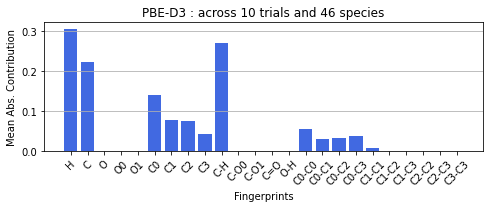

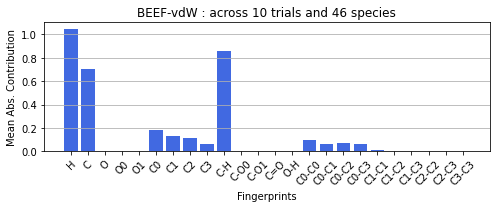

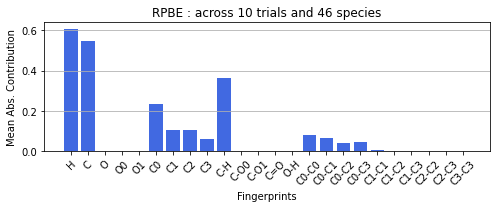

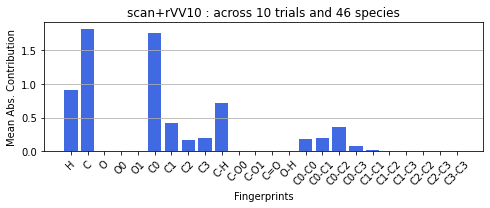

[2, 3, 4, 10, 11, 12, 13, 19, 20, 21, 22, 23]


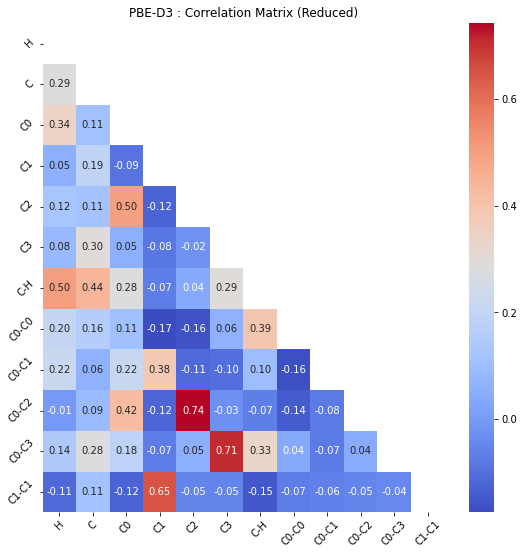

[2, 3, 4, 10, 11, 12, 13, 19, 20, 21, 22, 23]


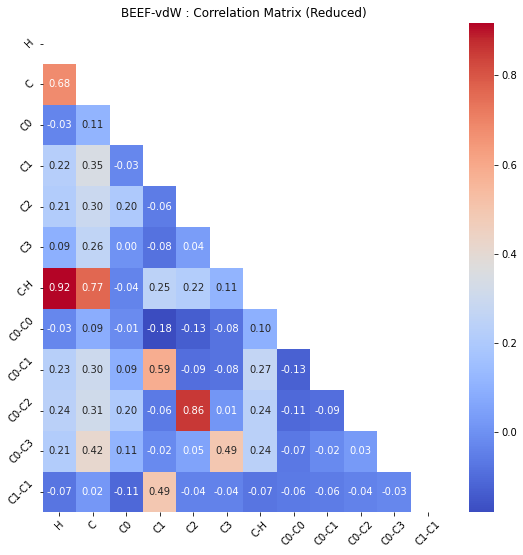

[2, 3, 4, 10, 11, 12, 13, 19, 20, 21, 22, 23]


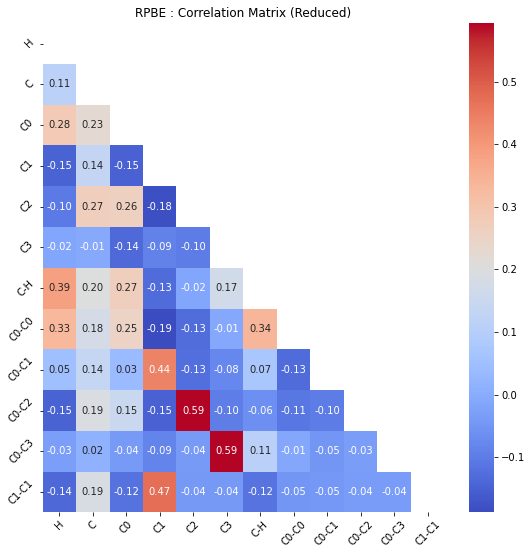

[2, 3, 4, 10, 11, 12, 13, 19, 20, 21, 22, 23]


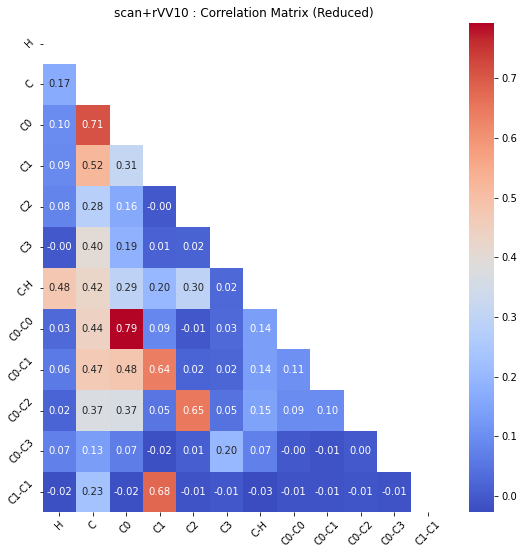

In [7]:
feature_labels = [
    'H', 'C', 'O', 'O0', 'O1', 'C0', 
    'C1', 'C2', 'C3', 'C-H', 'C-O0', 'C-O1', 
    'C=O', 'O-H', 'C0-C0', 'C0-C1', 'C0-C2', 'C0-C3', 
    'C1-C1', 'C1-C2', 'C1-C3', 'C2-C2', 'C2-C3', 'C3-C3'
]

for env_no, env_name in enumerate(['PBE-D3', 'BEEF-vdW', 'RPBE', 'scan+rVV10']):
    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 25), np.mean(d_stack[env_no], axis=0), color='royalblue', tick_label=feature_labels)
    plt.xlabel("Fingerprints")
    plt.ylabel("Mean Abs. Contribution")
    plt.title(str(env_name) + " : across 10 trials and 46 species")
    plt.xticks(rotation=45)  # Rotate labels to 90 degrees for better clarity
    plt.grid(axis='y')
    plt.tight_layout()  # Adjust layout to ensure all labels fit
    plt.show()

# # Calculate the means for each environment
# means_env = [np.mean(d_stack[env_no], axis=0) for env_no in range(4)]
# # Convert to a numpy array for easier manipulation
# data_for_correlation = np.array(means_env)
# # Calculate the correlation matrix
# corr_matrix = np.corrcoef(data_for_correlation)

# # Plotting the correlation matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
#             xticklabels=['PBE-D3', 'BEEF-vdW', 'RPBE', 'scan+rVV10'],
#             yticklabels=['PBE-D3', 'BEEF-vdW', 'RPBE', 'scan+rVV10'])
# plt.title("Correlation Matrix Across Environments")
# plt.show()


# for env_no, env_name in enumerate(['PBE-D3', 'BEEF-vdW', 'RPBE', 'scan+rVV10']):
#     corr_matrix = np.corrcoef(d_stack[env_no].T)
#     plt.figure(figsize=(12, 12))
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#     sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, xticklabels=feature_labels, yticklabels=feature_labels)
#     plt.title(f"{env_name} : across 10 trials and 46 species")
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=45)
#     plt.show()


for env_no, env_name in enumerate(['PBE-D3', 'BEEF-vdW', 'RPBE', 'scan+rVV10']):
    # Calculate the correlation matrix for the original data
    corr_matrix = np.corrcoef(d_stack[env_no].T)

    # Determine indices where all values in the correlation matrix are NaN
    indices_to_skip = [i for i in range(corr_matrix.shape[0]) if np.all(np.isnan(corr_matrix[i, :]))]

    print(indices_to_skip)
#     print(corr_matrix)
    # Filter out the rows and columns corresponding to the indices to skip
    filtered_corr_matrix = np.delete(corr_matrix, indices_to_skip, axis=0)
    filtered_corr_matrix = np.delete(filtered_corr_matrix, indices_to_skip, axis=1)

    # Adjusted feature labels (excluding the skipped indices)
    adjusted_feature_labels = [label for i, label in enumerate(feature_labels) if i not in indices_to_skip]

    # Plotting
    plt.figure(figsize=(9, 9))
    mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))
    sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, 
                xticklabels=adjusted_feature_labels, yticklabels=adjusted_feature_labels)
    plt.title(f"{env_name} : Correlation Matrix (Reduced)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
